In [124]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

from itertools import product

In [125]:
# # Graph example A: a graph with 9 nodes
# G = nx.Graph()
# G.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8])
# G.add_weighted_edges_from([(0, 1, 21), (0, 2, 25), (1, 3, 13), (2, 4, 11), (3, 5, 24), (3, 6, 23), (2, 4, 11), (4, 7, 27), (4, 8, 22)])
# labels = nx.get_edge_attributes(G,'weight')
# nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

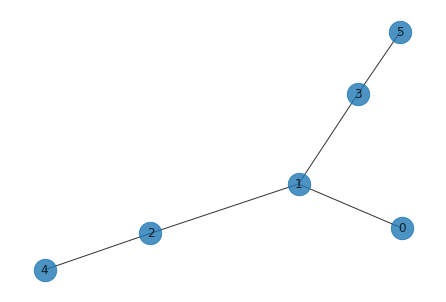

In [126]:
# Graph example B: a graph with 6 nodes
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4, 5])
G.add_weighted_edges_from([(0, 1, 21), (1, 2, 17), (1, 3, 15), (2, 4, 25), (3, 5, 27)])
labels = nx.get_edge_attributes(G,'weight')
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [127]:
adjacency = nx.adjacency_matrix(G).todense()
nnodes = G.number_of_nodes()
nclusters = 3
nqubits = nnodes * nclusters
print(adjacency)

[[ 0 21  0  0  0  0]
 [21  0 17 15  0  0]
 [ 0 17  0  0 25  0]
 [ 0 15  0  0  0 27]
 [ 0  0 25  0  0  0]
 [ 0  0  0 27  0  0]]


/var/folders/mg/8gpvb2h14g715mgrnnm1rp940000gn/T/ipykernel_89831/2614419114.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()


## Mixing Unitary

In [128]:
beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw()

┌───────────────┐
 q_0: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
 q_1: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
 q_2: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
 q_3: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
 q_4: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
 q_5: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
 q_6: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
 q_7: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
 q_8: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
 q_9: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
q_10: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
q_11: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
q_12: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
q_13: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
q_14: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
q_15: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
q_16: ┤ Rx(2*$\beta$) ├
      ├───────────────┤
q_17: ┤ Rx(2*$\beta$) ├
      └───────────────┘

## Problem Unitary (Cost Unitary)

### [1st term of the problem unitary] The term describing the graph geometry: Laplacian matrix

[[ 21 -21   0   0   0   0]
 [-21  53 -17 -15   0   0]
 [  0 -17  42   0 -25   0]
 [  0 -15   0  42   0 -27]
 [  0   0 -25   0  25   0]
 [  0   0   0 -27   0  27]]


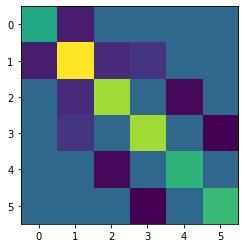

In [129]:
L = nx.laplacian_matrix(G, nodelist=None, weight='weight').todense()
print(L)
plt.imshow(L)

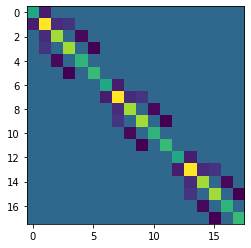

In [130]:
extended_L = np.zeros((nqubits, nqubits))
for i in range(nclusters):
    extended_L[i*nnodes:(i+1)*nnodes, i*nnodes:(i+1)*nnodes] += L
plt.imshow(extended_L)

### [2nd term of the problem unitary]  Constraint 1: the number of nodes in each cluster should be the same.

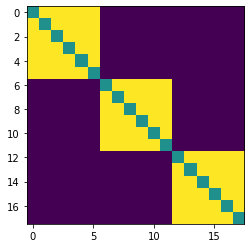

In [131]:
extended_c1 = np.zeros((nqubits, nqubits))

# quadratic terms
# naturally reduces to linear terms bc 1*1=1 and 0*0=0
for i in range(nqubits):
    extended_c1[i,i] += 1
#plt.imshow(extended_c1)

# linear terms
small_off_diagonal_matrix = np.ones((nnodes, nnodes))
for i in range(nnodes):
    small_off_diagonal_matrix[i, i] = 0
plt.plot()
# plt.imshow(small_off_diagonal_matrix)

for i in range(nclusters):
    extended_c1[i*nnodes:(i+1)*nnodes, i*nnodes:(i+1)*nnodes] += small_off_diagonal_matrix * (nnodes // nclusters)

plt.imshow(extended_c1)

### [3rd term of the problem unitary] Constraint 2: each node should be assigned to exactly one cluster.

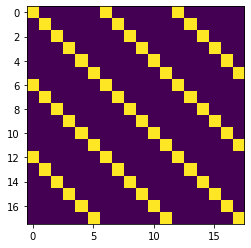

In [132]:
extended_c2 = np.zeros((nqubits, nqubits))

# quadratic terms
# naturally reduces to linear terms bc 1*1=1 and 0*0=0
for i in range(nqubits):
    extended_c2[i,i] += 1

# linear terms
small_diagonal_matrix = np.zeros((nnodes, nnodes))
for i in range(nnodes):
    small_diagonal_matrix[i, i] += 1

for i, j in product(np.arange(nclusters), np.arange(nclusters)):
    if i != j:
        extended_c2[i*nnodes: (i+1)*nnodes, j*nnodes: (j+1)*nnodes] += small_diagonal_matrix
        
plt.imshow(extended_c2)

### [total problem unitary] Weighted sum of the above 3 matrices

In [133]:
constraint_weight = 50
problem_unitary = extended_L + constraint_weight * extended_c1 + constraint_weight * 3 * extended_c2

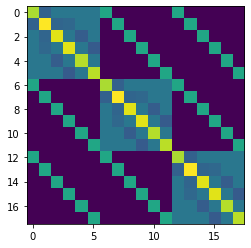

In [134]:
plt.imshow(problem_unitary)

### [total problem unitary] Converting the problem unitary to a quantum circuit
Each entry is a weighted ZZ gate